
### dataset = Crack 500



## Loading the important libraries and Dataset

In [1]:
! nvidia-smi

Sun Oct 11 22:22:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 37%   56C    P0    66W / 250W |    259MiB / 11011MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 77%   77C    P2   239W / 250W |  10973MiB / 11019MiB |     88%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score, precision_recall_curve
#!pip install albumentations
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE, RandomRotate90, ShiftScaleRotate

In [5]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

### Loading the data and splitting it into training and validation set.

In [6]:
########################
# Path Set

# Dataset_dir
dataset_name = 'CrackTree260'
dataset_dir = os.path.join('/data/crack', dataset_name)

train_image_dir = os.path.join(dataset_dir,'train','image')
train_mask_dir = os.path.join(dataset_dir,'train','mask')
val_image_dir = os.path.join(dataset_dir,'val','image')
val_mask_dir = os.path.join(dataset_dir,'val','mask')
test_image_dir = os.path.join(dataset_dir,'test','image')
test_mask_dir = os.path.join(dataset_dir,'test','mask')

# model path

modelSave_name = "concrete_cracks_{}.h5".format(dataset_name)
model_path = os.path.join(dataset_dir, modelSave_name)

In [7]:
#########################
# USER Set

mode_run_type = ['train', 'inference']
mode_run = mode_run_type[0] # 0 is train, 1 is inference

set_valid = True # In train, if valid or not.
set_split_val = True
number_set_train = 234

os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [8]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])
if set_valid:
    val_image_paths = sorted([os.path.join(val_image_dir, fname) for fname in os.listdir(val_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
    val_mask_paths = sorted([os.path.join(val_mask_dir, fname) for fname in os.listdir(val_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

    test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
    test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))


print('\n')
if set_valid:
    print("Number of validating images : ", len(val_image_paths))
    print("Number of validating masks : ", len(val_mask_paths))
    print('\n')
    print("Number of testing images : ", len(test_image_paths))
    print("Number of testing masks : ", len(test_mask_paths))

Number of training images :  260
Number of training masks :  260


Number of validating images :  40
Number of validating masks :  40


Number of testing images :  315
Number of testing masks :  315


In [9]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [10]:
# Splitting
train_image_files = train_image_paths
train_mask_files = train_mask_paths

if set_valid:
    if set_split_val:
        train_image_files = train_image_paths[:number_set_train]
        train_mask_files = train_mask_paths[:number_set_train]                             
        val_image_files = train_image_paths[number_set_train:]
        val_mask_files = train_mask_paths[number_set_train:]
                                            
    else:
        val_image_files = val_image_paths
        val_mask_files = val_mask_paths                                    

print(len(train_image_files), len(train_mask_files))

if set_valid:
    print(len(val_image_files), len(val_mask_files))


234 234
26 26


In [11]:
batch_size = 13
img_dim=(256, 256)

# Generator to load and augment the image batch wise

In [12]:
class Generator(Sequence):
    def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.img_dim = img_dim
        self.augment = augment

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    """
    augmentations = Compose(
      [
          Flip(p=0.7),
          Rotate(p=0.7),
          RandomRotate90(p=0.3),
          ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=90, p=0.2),
          OneOf([
                  RandomContrast(),
                  RandomGamma(),
                  RandomBrightness()
                ], p=0.3),
          OneOf([
                  ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                  GridDistortion(),
                  OpticalDistortion(distort_limit=2, shift_limit=0.5)
                ], p=0.3),
      ])
    """
    
    augmentations = Compose(
      [
          Flip(p=0.7),
          Rotate(p=0.7),
          RandomRotate90(p=0.3),
          ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=90, p=0.2),
          OneOf([
                  RandomContrast(),
                  RandomGamma(),
                  RandomBrightness()
                ], p=0.3),
          OneOf([
                  ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                  GridDistortion(),
                  OpticalDistortion(distort_limit=2, shift_limit=0.5)
                ], p=0.3),
      ])
        
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
        batch_y = np.array([(cv2.resize(cv2.imread(file_name, -1), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])


        if self.augment is True:
            aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
            batch_x = np.array([i['image'] for i in aug])
            batch_y = np.array([j['mask'] for j in aug])
            
            '''
            batch_xx = batch_x
            batch_yy = batch_y

            for ii in range(10-1):
                aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_xx, batch_yy)]
                #batch_x = np.vstack([batch_x, np.array([i['image'] for i in aug])])
                #batch_y = np.vstack([batch_y, np.array([j['mask'] for j in aug])])
                batch_x = np.array(batch_x, [i['image'] for i in aug])
                batch_y = np.array(batch_x, [j['mask'] for j in aug])
            '''

        batch_y = np.expand_dims(batch_y, -1)
        
        return batch_x/255, batch_y/1  

In [13]:
if set_valid:
    test1_generator=Generator(test_image_paths, test_mask_paths)

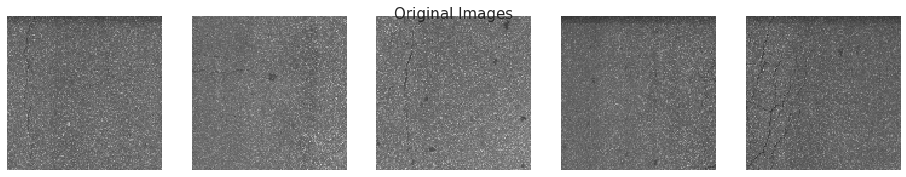

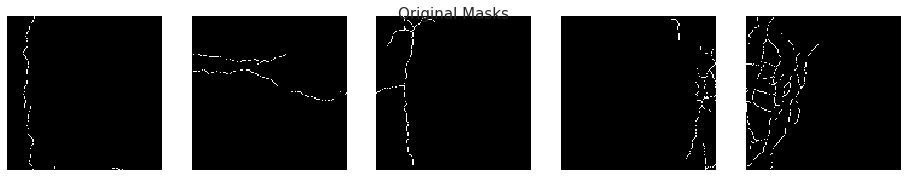

In [14]:
if set_valid:
    # Validation generator samples (Un-augmented)
    for i, j in test1_generator:
        break

    fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
    fig.suptitle('Original Images', fontsize=15)
    axes = axes.flatten()
    for img, ax in zip(i[:5], axes[:5]):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
    fig.suptitle('Original Masks', fontsize=15)
    axes = axes.flatten()
    for img, ax in zip(j[:5], axes[:5]):
        ax.imshow(np.squeeze(img, -1), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
train_generator = Generator(train_image_files, train_mask_files)

if set_valid:
    validation_generator = Generator(val_image_files, val_mask_files)


In [16]:
for i, j in train_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [17]:
if set_valid:
    for i, j in validation_generator:
      break

    print(i.shape)
    print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


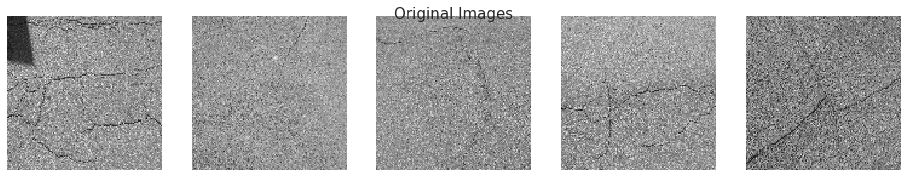

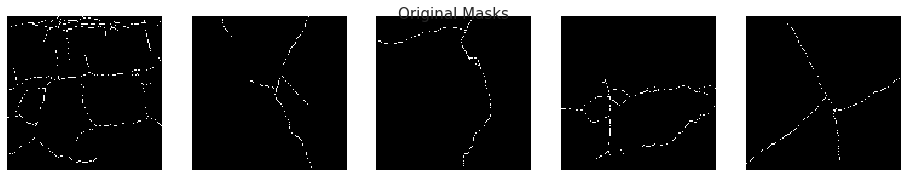

In [18]:
# Train generator samples (Un-augmented)
for i, j in train_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

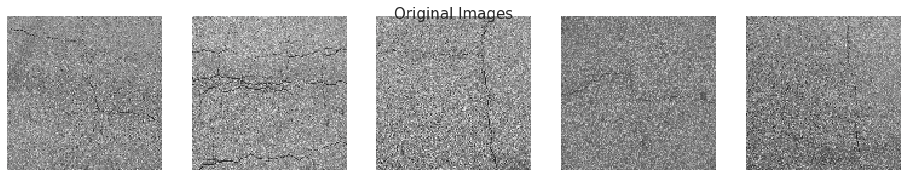

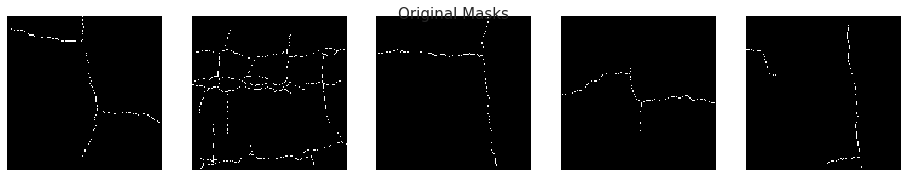

In [19]:
if set_valid:
    # Validation generator samples (Un-augmented)
    for i, j in validation_generator:
        break

    fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
    fig.suptitle('Original Images', fontsize=15)
    axes = axes.flatten()
    for img, ax in zip(i[:5], axes[:5]):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
    fig.suptitle('Original Masks', fontsize=15)
    axes = axes.flatten()
    for img, ax in zip(j[:5], axes[:5]):
        ax.imshow(np.squeeze(img, -1), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [20]:
tg = Generator(train_image_files, train_mask_files, batch_size, img_dim, augment = True)


if set_valid:
    vg = Generator(val_image_files, val_mask_files, batch_size, img_dim, augment = False)

In [21]:
def visualize(image_x, image_y):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image_x)
    plt.show()
        
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(np.squeeze(image_y, -1), cmap='gray')
    plt.show()

In [22]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(13, 256, 256, 3)
(13, 256, 256, 1)


In [23]:
if set_valid:
    for i, j in vg:
      break

    print(i.shape)
    print(j.shape)

(13, 256, 256, 3)
(13, 256, 256, 1)


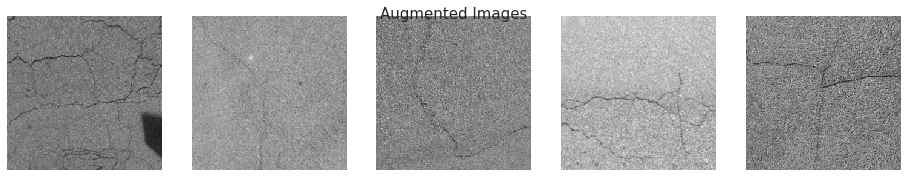

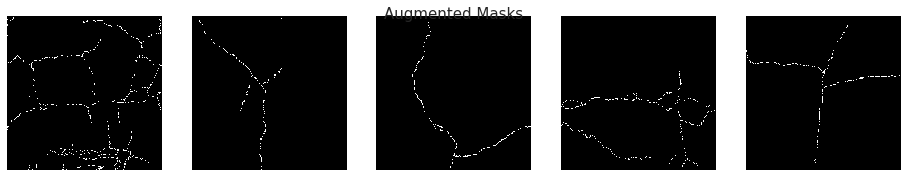

In [24]:
# Augmented train
for i, j in tg:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model

In [25]:
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Input, Activation, Concatenate
from keras.regularizers import l2

Using TensorFlow backend.


In [26]:
# BatchNormalization and Activation
def BN_Act(x, act = True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

In [27]:
#conv2d block
def conv2d_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    conv = BN_Act(x)
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(conv)
    return conv

In [28]:
#Fixed layer.
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
    conv = conv2d_block(conv, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    
    #skip
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([conv, shortcut])
    return output

In [29]:
# Residual Block
def residual_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    res = conv2d_block(x, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    res = conv2d_block(res, filters, kernel_size = kernel_size, padding = padding, strides = 1)
    
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([shortcut, res])
    return output

In [30]:
# Upsampling Concatenation block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [31]:
# MODEL
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_dim[0], img_dim[1], 3))
    
    ## Encoder/downsampling/contracting path
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides = 2)
    e3 = residual_block(e2, f[2], strides = 2)
    e4 = residual_block(e3, f[3], strides = 2)
    e5 = residual_block(e4, f[4], strides = 2)
    
    ## Bridge/Bottleneck
    b0 = conv2d_block(e5, f[4], strides = 1)
    b1 = conv2d_block(b0, f[4], strides = 1)
    
    ## Decoder/upsampling/expansive path
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding = "same", activation = "sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

In [32]:
K.clear_session()
model = ResUNet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

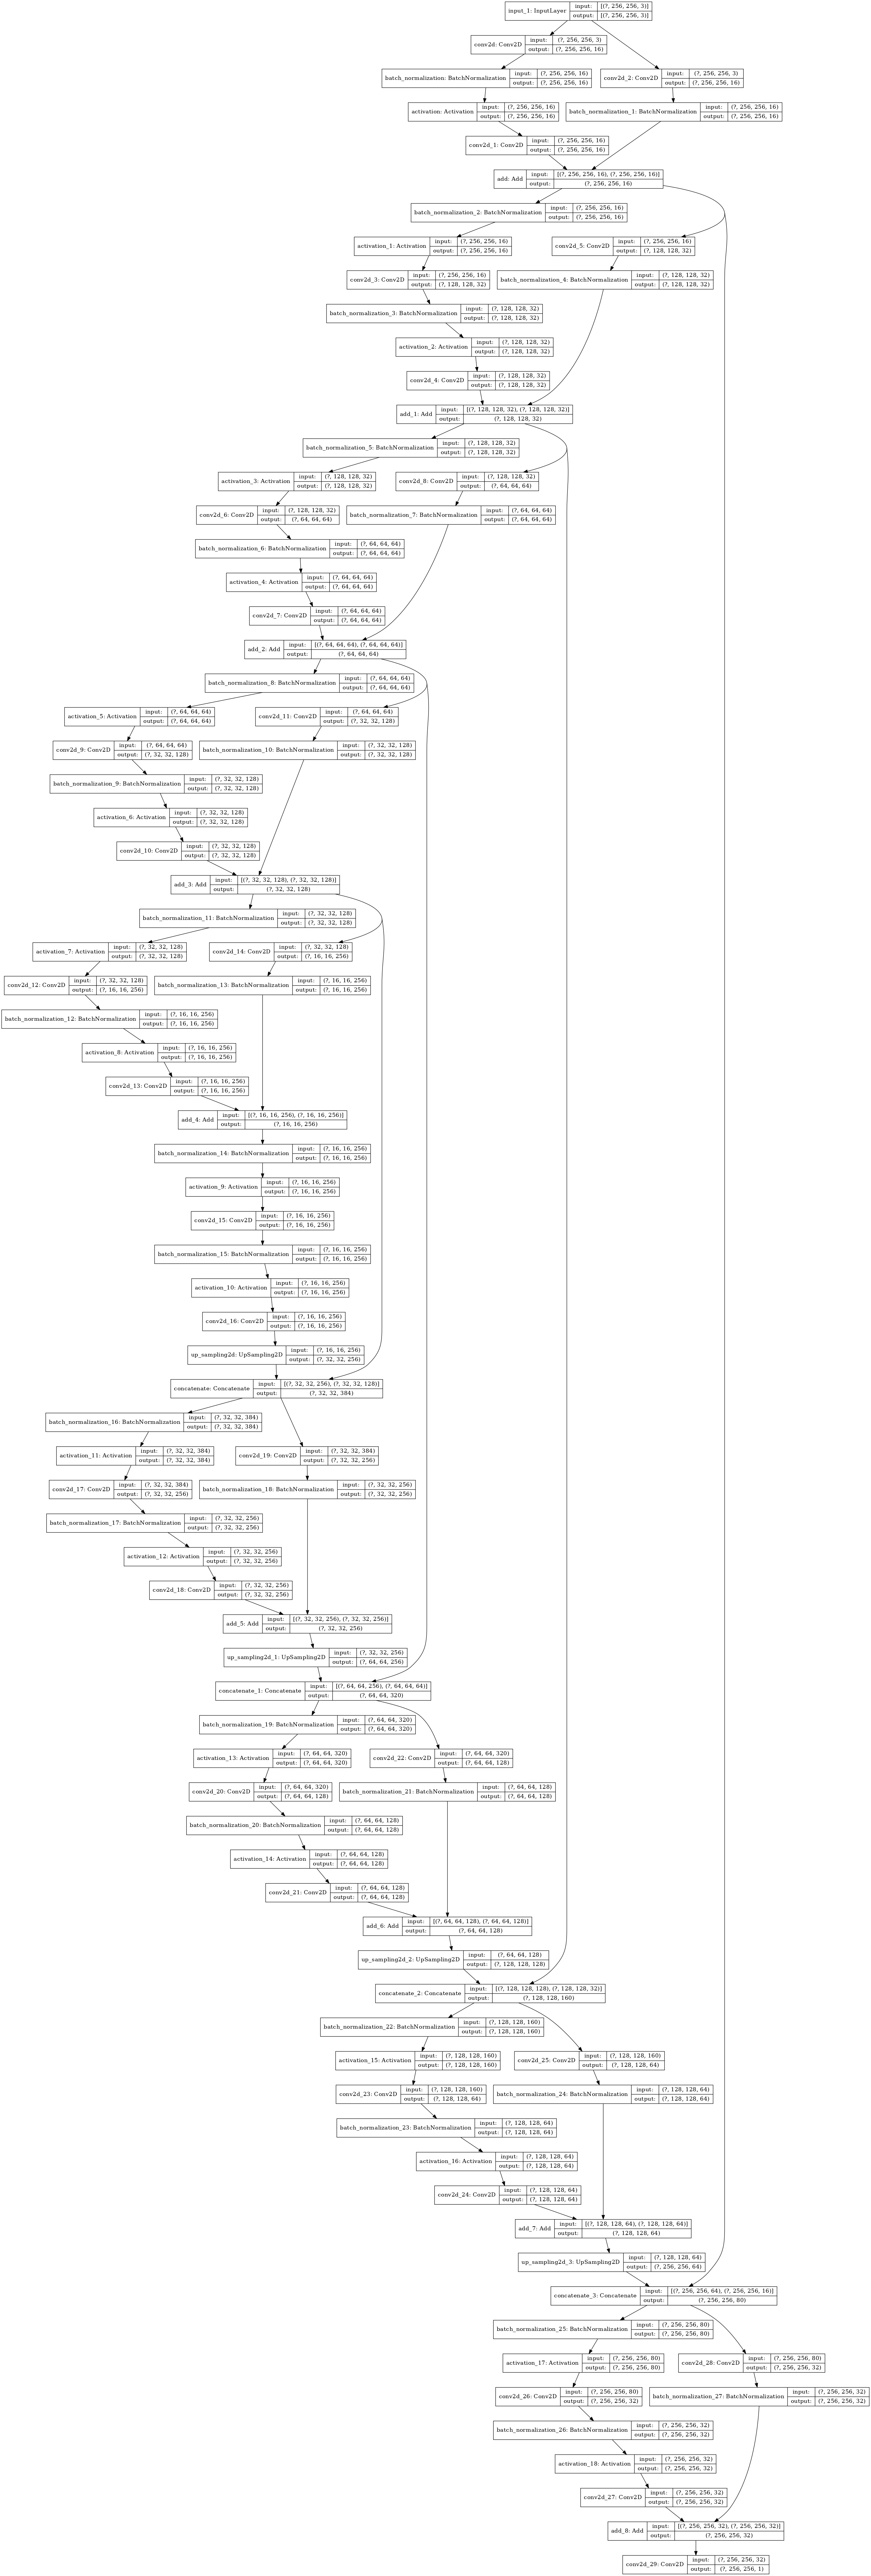

In [34]:
from tensorflow.keras.utils import  plot_model

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100,
)

# Loss
# &
# Compile

In [70]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
'''
def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5
    

    
    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou
'''
def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()
    #intersection = K.sum(K.minimum(y_true_2px, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou


In [71]:
def lr_schedule(epoch):

    lr =0.001
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

In [73]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


In [74]:
import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)

#from tensorflow.keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=4)


#from tensorflow.keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=2, cpu_merge=True, cpu_relocation=False)

model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

Learning rate:  0.001


# Training

In [76]:
train_steps = len(train_image_files)//batch_size

if set_valid:
    valid_steps = len(val_image_files)//batch_size

if not set_valid:
    vg = None
    valid_steps = None
    
history = model.fit(
    tg, 
    steps_per_epoch=train_steps,
    initial_epoch = 0,
    epochs=200,
    validation_data = vg,    
    validation_steps = valid_steps,callbacks=callbacks)

Learning rate:  0.001
Epoch 1/200
18/18 [==============================] - 12s 678ms/step - loss: 0.8715 - acc: 0.8827 - IOU: 0.0890 - dice_coef: 0.1285 - val_loss: 0.9987 - val_acc: 0.9831 - val_IOU: 6.3467e-04 - val_dice_coef: 0.0013
Learning rate:  0.001
Epoch 2/200
18/18 [==============================] - 4s 200ms/step - loss: 0.6995 - acc: 0.9832 - IOU: 0.1911 - dice_coef: 0.3005 - val_loss: 0.9995 - val_acc: 0.9859 - val_IOU: 2.0604e-04 - val_dice_coef: 4.9619e-04
Learning rate:  0.001
Epoch 3/200
18/18 [==============================] - 4s 201ms/step - loss: 0.6558 - acc: 0.9849 - IOU: 0.2176 - dice_coef: 0.3442 - val_loss: 0.9999 - val_acc: 0.9897 - val_IOU: 1.1428e-11 - val_dice_coef: 1.1427e-04
Learning rate:  0.001
Epoch 4/200
18/18 [==============================] - 4s 201ms/step - loss: 0.6105 - acc: 0.9862 - IOU: 0.2508 - dice_coef: 0.3895 - val_loss: 0.9999 - val_acc: 0.9896 - val_IOU: 1.1411e-11 - val_dice_coef: 1.1407e-04
Learning rate:  0.001
Epoch 5/200
18/18 [======

Learning rate:  0.001
Epoch 24/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4626 - acc: 0.9888 - IOU: 0.3704 - dice_coef: 0.5374 - val_loss: 0.3706 - val_acc: 0.9926 - val_IOU: 0.4642 - val_dice_coef: 0.6294
Learning rate:  0.001
Epoch 25/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4627 - acc: 0.9885 - IOU: 0.3702 - dice_coef: 0.5373 - val_loss: 0.3461 - val_acc: 0.9930 - val_IOU: 0.4886 - val_dice_coef: 0.6539
Learning rate:  0.001
Epoch 26/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4412 - acc: 0.9894 - IOU: 0.3905 - dice_coef: 0.5588 - val_loss: 0.3564 - val_acc: 0.9930 - val_IOU: 0.4774 - val_dice_coef: 0.6436
Learning rate:  0.001
Epoch 27/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4480 - acc: 0.9892 - IOU: 0.3835 - dice_coef: 0.5520 - val_loss: 0.3292 - val_acc: 0.9933 - val_IOU: 0.5078 - val_dice_coef: 0.6708
Learning rate:  0.001
Epoch 28/200
18/18 [==============================

18/18 [==============================] - 4s 202ms/step - loss: 0.4528 - acc: 0.9888 - IOU: 0.3788 - dice_coef: 0.5472 - val_loss: 0.3169 - val_acc: 0.9929 - val_IOU: 0.5193 - val_dice_coef: 0.6831
Learning rate:  0.0005
Epoch 48/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4364 - acc: 0.9893 - IOU: 0.3940 - dice_coef: 0.5636 - val_loss: 0.3138 - val_acc: 0.9931 - val_IOU: 0.5233 - val_dice_coef: 0.6862
Learning rate:  0.0005
Epoch 49/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4472 - acc: 0.9890 - IOU: 0.3834 - dice_coef: 0.5528 - val_loss: 0.3146 - val_acc: 0.9931 - val_IOU: 0.5231 - val_dice_coef: 0.6854
Learning rate:  0.0005
Epoch 50/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4421 - acc: 0.9891 - IOU: 0.3886 - dice_coef: 0.5579 - val_loss: 0.3117 - val_acc: 0.9931 - val_IOU: 0.5262 - val_dice_coef: 0.6883
Learning rate:  0.0005
Epoch 51/200
18/18 [==============================] - 4s 202ms/step - loss: 0.446

18/18 [==============================] - 4s 202ms/step - loss: 0.4275 - acc: 0.9895 - IOU: 0.4025 - dice_coef: 0.5725 - val_loss: 0.3096 - val_acc: 0.9930 - val_IOU: 0.5277 - val_dice_coef: 0.6904
Learning rate:  0.0005
Epoch 71/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4325 - acc: 0.9892 - IOU: 0.3976 - dice_coef: 0.5675 - val_loss: 0.3168 - val_acc: 0.9928 - val_IOU: 0.5201 - val_dice_coef: 0.6832
Learning rate:  0.0005
Epoch 72/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4352 - acc: 0.9893 - IOU: 0.3948 - dice_coef: 0.5648 - val_loss: 0.3070 - val_acc: 0.9932 - val_IOU: 0.5313 - val_dice_coef: 0.6930
Learning rate:  0.0005
Epoch 73/200
18/18 [==============================] - 4s 203ms/step - loss: 0.4367 - acc: 0.9893 - IOU: 0.3939 - dice_coef: 0.5633 - val_loss: 0.3147 - val_acc: 0.9931 - val_IOU: 0.5213 - val_dice_coef: 0.6853
Learning rate:  0.0005
Epoch 74/200
18/18 [==============================] - 4s 198ms/step - loss: 0.433

18/18 [==============================] - 4s 202ms/step - loss: 0.4403 - acc: 0.9891 - IOU: 0.3898 - dice_coef: 0.5597 - val_loss: 0.3099 - val_acc: 0.9931 - val_IOU: 0.5288 - val_dice_coef: 0.6901
Learning rate:  0.0005
Epoch 94/200
18/18 [==============================] - 4s 197ms/step - loss: 0.4292 - acc: 0.9895 - IOU: 0.4006 - dice_coef: 0.5708 - val_loss: 0.3076 - val_acc: 0.9931 - val_IOU: 0.5309 - val_dice_coef: 0.6924
Learning rate:  0.0005
Epoch 95/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4324 - acc: 0.9893 - IOU: 0.3979 - dice_coef: 0.5676 - val_loss: 0.3123 - val_acc: 0.9931 - val_IOU: 0.5244 - val_dice_coef: 0.6877
Learning rate:  0.0005
Epoch 96/200
18/18 [==============================] - 4s 203ms/step - loss: 0.4271 - acc: 0.9896 - IOU: 0.4028 - dice_coef: 0.5729 - val_loss: 0.3043 - val_acc: 0.9933 - val_IOU: 0.5342 - val_dice_coef: 0.6957
Learning rate:  0.0005
Epoch 97/200
18/18 [==============================] - 4s 196ms/step - loss: 0.424

18/18 [==============================] - 4s 196ms/step - loss: 0.4211 - acc: 0.9897 - IOU: 0.4088 - dice_coef: 0.5789 - val_loss: 0.3112 - val_acc: 0.9933 - val_IOU: 0.5255 - val_dice_coef: 0.6888
Learning rate:  0.0005
Epoch 117/200
18/18 [==============================] - 4s 203ms/step - loss: 0.4231 - acc: 0.9898 - IOU: 0.4066 - dice_coef: 0.5769 - val_loss: 0.3089 - val_acc: 0.9930 - val_IOU: 0.5290 - val_dice_coef: 0.6911
Learning rate:  0.0005
Epoch 118/200
18/18 [==============================] - 4s 197ms/step - loss: 0.4262 - acc: 0.9896 - IOU: 0.4036 - dice_coef: 0.5738 - val_loss: 0.3044 - val_acc: 0.9933 - val_IOU: 0.5341 - val_dice_coef: 0.6956
Learning rate:  0.0005
Epoch 119/200
18/18 [==============================] - 4s 196ms/step - loss: 0.4317 - acc: 0.9892 - IOU: 0.3981 - dice_coef: 0.5683 - val_loss: 0.3074 - val_acc: 0.9933 - val_IOU: 0.5297 - val_dice_coef: 0.6926
Learning rate:  0.0005
Epoch 120/200
18/18 [==============================] - 4s 202ms/step - loss: 0

18/18 [==============================] - 4s 196ms/step - loss: 0.4382 - acc: 0.9888 - IOU: 0.3917 - dice_coef: 0.5618 - val_loss: 0.3025 - val_acc: 0.9934 - val_IOU: 0.5354 - val_dice_coef: 0.6975
Learning rate:  0.0005
Epoch 140/200
18/18 [==============================] - 4s 196ms/step - loss: 0.4309 - acc: 0.9894 - IOU: 0.3989 - dice_coef: 0.5691 - val_loss: 0.3037 - val_acc: 0.9933 - val_IOU: 0.5350 - val_dice_coef: 0.6963
Learning rate:  0.0005
Epoch 141/200
18/18 [==============================] - 4s 195ms/step - loss: 0.4265 - acc: 0.9894 - IOU: 0.4029 - dice_coef: 0.5735 - val_loss: 0.3009 - val_acc: 0.9934 - val_IOU: 0.5377 - val_dice_coef: 0.6991
Learning rate:  0.0005
Epoch 142/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4302 - acc: 0.9893 - IOU: 0.3999 - dice_coef: 0.5698 - val_loss: 0.2994 - val_acc: 0.9935 - val_IOU: 0.5393 - val_dice_coef: 0.7006
Learning rate:  0.0005
Epoch 143/200
18/18 [==============================] - 4s 201ms/step - loss: 0

18/18 [==============================] - 4s 195ms/step - loss: 0.4252 - acc: 0.9894 - IOU: 0.4047 - dice_coef: 0.5748 - val_loss: 0.3007 - val_acc: 0.9935 - val_IOU: 0.5383 - val_dice_coef: 0.6993
Learning rate:  0.0005
Epoch 163/200
18/18 [==============================] - 4s 202ms/step - loss: 0.4220 - acc: 0.9895 - IOU: 0.4077 - dice_coef: 0.5780 - val_loss: 0.3030 - val_acc: 0.9932 - val_IOU: 0.5355 - val_dice_coef: 0.6970
Learning rate:  0.0005
Epoch 164/200
18/18 [==============================] - 4s 201ms/step - loss: 0.4289 - acc: 0.9894 - IOU: 0.4007 - dice_coef: 0.5711 - val_loss: 0.3065 - val_acc: 0.9930 - val_IOU: 0.5314 - val_dice_coef: 0.6935
Learning rate:  0.0005
Epoch 165/200
18/18 [==============================] - 4s 196ms/step - loss: 0.4259 - acc: 0.9894 - IOU: 0.4037 - dice_coef: 0.5741 - val_loss: 0.3023 - val_acc: 0.9933 - val_IOU: 0.5357 - val_dice_coef: 0.6977
Learning rate:  0.0005
Epoch 166/200
18/18 [==============================] - 4s 195ms/step - loss: 0

18/18 [==============================] - 4s 195ms/step - loss: 0.4197 - acc: 0.9897 - IOU: 0.4094 - dice_coef: 0.5803 - val_loss: 0.3017 - val_acc: 0.9934 - val_IOU: 0.5369 - val_dice_coef: 0.6983
Learning rate:  0.0005
Epoch 186/200
18/18 [==============================] - 4s 195ms/step - loss: 0.4213 - acc: 0.9895 - IOU: 0.4082 - dice_coef: 0.5787 - val_loss: 0.3006 - val_acc: 0.9934 - val_IOU: 0.5381 - val_dice_coef: 0.6994
Learning rate:  0.0005
Epoch 187/200
18/18 [==============================] - 4s 195ms/step - loss: 0.4147 - acc: 0.9898 - IOU: 0.4150 - dice_coef: 0.5853 - val_loss: 0.2994 - val_acc: 0.9935 - val_IOU: 0.5391 - val_dice_coef: 0.7006
Learning rate:  0.0005
Epoch 188/200
18/18 [==============================] - 4s 201ms/step - loss: 0.4154 - acc: 0.9900 - IOU: 0.4140 - dice_coef: 0.5846 - val_loss: 0.3067 - val_acc: 0.9929 - val_IOU: 0.5312 - val_dice_coef: 0.6933
Learning rate:  0.0005
Epoch 189/200
18/18 [==============================] - 4s 195ms/step - loss: 0

In [77]:
# Model save
model.save(model_path)

In [78]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

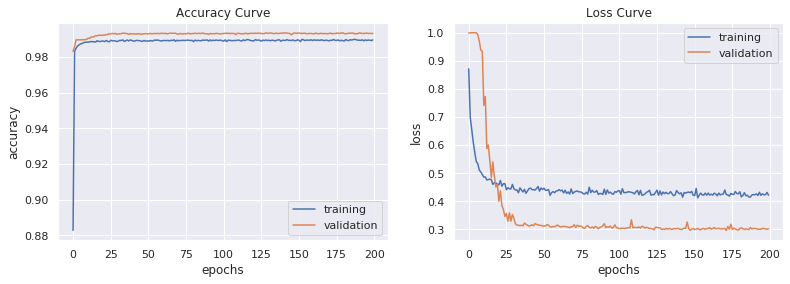

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [80]:
train_dice = history.history['dice_coef']
valid_dice = history.history['val_dice_coef']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

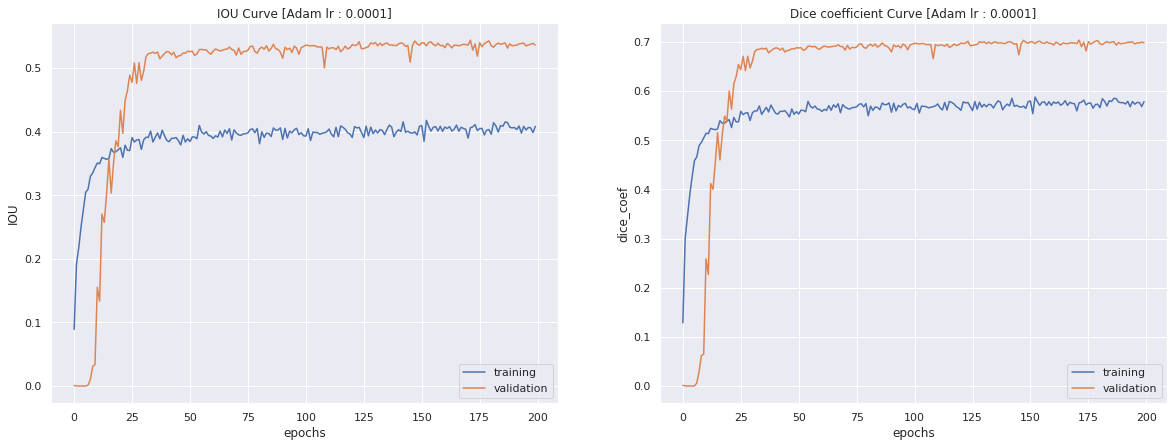

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve [Adam lr : 0.0001]')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve [Adam lr : 0.0001]')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

## Testing

In [82]:
model.load_weights(model_path)

print("Loaded model from disk")

Loaded model from disk


In [83]:
num_val_files = len(val_image_files)
test_generator = Generator(val_image_files, val_mask_files, num_val_files, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)
print(y_pred.shape)
print(y_pred.shape)
yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

(26, 256, 256, 1)
(26, 256, 256, 1)


In [84]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)
AP = average_precision_score(y_test.flatten(), y_pred.flatten())

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("AP: {0:.4f}\n".format(AP))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9933

AP: 0.6177

Precision: 0.6499

Recall: 0.7531

F1-Score: 0.6977

Sensitivity: 0.7531

Specificity: 0.9958

AUC: 0.9197

IOU: 0.5358

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1686315
        True       0.65      0.75      0.70     17621

    accuracy                           0.99   1703936
   macro avg       0.82      0.87      0.85   1703936
weighted avg       0.99      0.99      0.99   1703936



In [85]:
for i, j in test1_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [86]:
ttg = Generator(test_image_paths,test_mask_paths, batch_size, img_dim, augment = False)

In [87]:
for i, j in ttg:
  break

print(i.shape)
print(j.shape)

(13, 256, 256, 3)
(13, 256, 256, 1)


In [ ]:
num_test_files = len(test_image_paths)
test_generator1 = Generator(test_image_paths,test_mask_paths,num_test_files, img_dim)

for x_test, y_test in test_generator1:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

In [ ]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)
AP = average_precision_score(y_test.flatten(), y_pred.flatten())

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("AP: {0:.4f}\n".format(AP))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))




In [ ]:
def plot_image(i, predictions_array, img):
  img = img[i]

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])   
  indices = np.where(predictions_array!=[0])

  plt.imshow(img)#, cmap=plt.cm.binary)
  save_path = '/home/adip/crack_ws/src/datasets/Crack500/results/mask'
  cv2.imwrite(os.path.join(save_path, '{}.png'.format(i)), img)
